# CNN using only NumPy

In this Colab, I will walk you through implementing a 3-layer CNN from scratch (using NumPy)

In [ ]:
# Importing necessary libraries

import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
#import keras
#from tensorflow.examples.tutorials.mnist import input_data

First we will load a test image and we will forward and back progate to build our intution

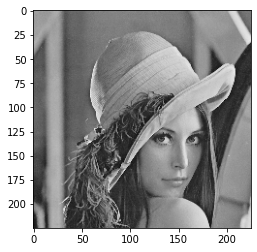

(225, 225)

In [ ]:
# Loading a test Image

img  = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)/255
img = img[:225, :225]
plt.imshow(img, cmap = "gray")
plt.show()
img.shape

## Convolution Layer

Here, I will go through the forward and back propogation of Convolution Layer.


In [ ]:
# Defining the Conv Layer Operations
class Conv_Layer:
    
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size**2)
    
    # First, we will define a function that will loop over through the input image, 
    # and extract us the filter size patches from it. Here, for simplicity, we use the stride of 1. 
    def image_region(self, image):
        height, width = image.shape
        self.image = image
        for j in range(height - self.filter_size + 1):
            for k in range(width - self.filter_size + 1):
                image_patch = image[ j:(j+self.filter_size), k:(k+self.filter_size)]
                yield image_patch, j, k #size of image_patch will be height x width
        
    def forward_prop(self, image):
        height, width = image.shape
        conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters)) # (num_filters, filter_size, filter_size)
        for image_patch, i, j in self.image_region(image):
            conv_out[i,j] = np.sum(image_patch * self.conv_filter, axis = (1,2))
            # The image_patch will be broadcasted to the shape of self.conv_filter and 
            # then multiplied with it. It is then summed over axis = 1 and 2 
            # which are the height and width of the filters and hence conv_out 
            # will be a vector of size=(height, width, num_filters) 
        return conv_out
    
    def back_prop(self, dL_dout, learning_rate):
      # dL_dout is coming from the next Maxpool layer
        dL_dF_params = np.zeros(self.conv_filter.shape) # init a placeholder for sotring dL_dF params
        for image_patch, i, j in self.image_region(self.image):
            for k in range(self.num_filters):
                dL_dF_params[k] += image_patch*dL_dout[i,j,k]
        # weight update rule
        self.conv_filter -= learning_rate * dL_dF_params
        return dL_dF_params

In [ ]:
# Initiating the first layer
layer1 = Conv_Layer(4, 7) # 4 x 7 x 7

out_l1 = layer1.forward_prop(img)
out_l1.shape

(219, 219, 4)

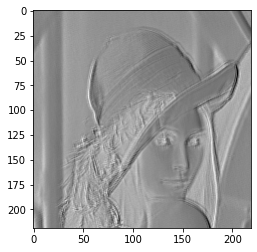

In [ ]:
plt.imshow(out[:,:,3], cmap = "gray")
plt.show()

In [ ]:
# Defining the Max Pooling Operations

class Max_Pool:
    def __init__(self, filter_size):
        self.filter_size = filter_size
    
    def image_region(self, image):
        new_height = image.shape[0] // self.filter_size
        new_width = image.shape[1] // self.filter_size
        self.image = image
        
        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[(i): (i + self.filter_size),
                                   (j): (j + self.filter_size)]
                yield image_patch, i, j # Size of image patch will be height, width, num_filters
                
    def forward_prop(self, image):
        height, width, num_filters = image.shape
        output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))
        
        for image_patch, i, j in self.image_region(image):
            output[i,j] = np.amax(image_patch, axis = (0,1))
            
        return output
    
    def back_prop(self, dL_dout):
        dL_dmax_pool = np.zeros(self.image.shape)

        for image_patch, i, j in self.image_region(self.image):
            height, width, num_filters = image_patch.shape
            maximum_val = np.amax(image_patch, axis=(0,1))
            
            for i1 in range(height):
                for j1 in range(width):
                    for k1 in range(num_filters):
                        if image_patch[i1, j1, k1] == maximum_val[k1]:
                            dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1, k1] = dL_dout[i,j,k1]

            return dL_dmax_pool

In [ ]:
# Initiating the second layer

layer_2 = Max_Pool(5)
out_l2 = layer_2.forward_prop(out_l1)
out_l2.shape

(43, 43, 4)

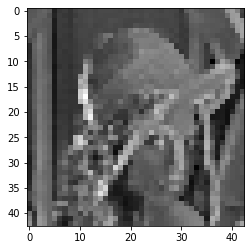

In [ ]:
plt.imshow(out2[:,:,3], cmap = "gray")
plt.show()

In [ ]:
# Defining the Softmax Layer Operations

class Softmax:
    def __init__(self, input_node, softmax_node):
        self.weight = np.random.randn(input_node, softmax_node) / input_node
        self.bias = np.zeros(softmax_node)
        
    def forward_prop(self, image):
        self.orig_im_shape = image.shape # used in backprop
        image_modified = image.flatten()
        self.modified_input = image_modified # to be used in backprop
        output_val = np.dot(image_modified, self.weight) + self.bias
        self.out = output_val
        exp_out= np.exp(output_val)
        return exp_out/np.sum(exp_out, axis = 0)
    
    def back_prop(self, dL_dy, learning_rate):

        for i, dL_dy_ in enumerate(dL_dy):
            if dL_dy_ == 0:
                continue # skip the rest of code

            y = np.exp(self.out) / np.sum(np.exp(self.out))
            
            # Gradient of y with respect to out (z)
            dy_dz = - y[i] * y
            dy_dz[i] = y[i] * ( 1 - y[i] )

            # gradients of totals against weights/biases/input (z w.r.t weights/biases/input )
            dz_dw = self.modified_input
            dz_db = 1
            dz_d_inp = self.weight
            
            # gradients of loss against totals
            dL_dz = dL_dy_ * dy_dz 
            
            # gradients of loss against weights/biases/input
            dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis] #@ for convonential matrix muultiplication, np.newaxis for adding additional row
            dL_db = dL_dz * dz_db
            dL_d_inp = dz_d_inp @ dL_dz
            
            # update weights and biases
            self.weight -= learning_rate * dL_dw
            self.bias -= learning_rate * dL_db
            
            return dL_d_inp.reshape(self.orig_im_shape)

In [ ]:
layer_3 = Softmax(43*43*4, 10)
out_l3 = conn3.forward_prop(out_l2)
print(out_l3)

[0.10002044 0.0999717  0.09993696 0.09999288 0.09995101 0.10000981
 0.10003632 0.10007284 0.0999561  0.10005195]


## Single forward and bacward pass

In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_images = X_train[:1500]
train_labels = y_train[:1500]
test_images = X_test[:1500]
test_labels = y_test[:1500]

# Picking up single image and its label
label_d = train_labels[1]
image_d = train_images[1]

In [ ]:
learn_rate = 0.005

conv = Conv_op(8,3) # 28.28.2 - 26.26.8
pool = Max_Pool(2) #26.26.8 - 13.13.8
softmax = Softmax(13 * 13 * 8, 10) # 13.13.8 - 10

out_p = conv.forward_prop((image_d/255)-.5)
out_p.shape
out_p = pool.forward_prop(out_p)
out_p.shape
out_p = softmax.forward_prop(out_p)
out_p.shape


(10,)

In [ ]:
#calculate cross entropy loss
cross_ent_loss = -np.log(out_p[label_d])
print(cross_ent_loss)

2.3059256790885203


In [ ]:
#calculate dL_dy gradient
gradient = np.zeros(10)
print("out_p[label]",out_p[label_d])
gradient[label_d] = -1 /out_p[label_d]

out_p[label] 0.09966649874552179


In [ ]:
grad_back = softmax.back_prop(gradient, learn_rate)
grad_back = pool.back_prop(grad_back)
grad_back = conv.back_prop(grad_back, learn_rate)

print("Weights updated.")

Weights updated.


## Testing CNN on MNIST dataset

In [ ]:
# Considering only first 1500 images in the dataset
train_images = X_train[:1500]
train_labels = y_train[:1500]
test_images = X_test[:1500]
test_labels = y_test[:1500]

# Defining network
conv = Conv_op(8,3) # 28.28.2 - 26.26.8
pool = Max_Pool(2) #26.26.8 - 13.13.8
softmax = Softmax(13 * 13 * 8, 10) # 13.13.8 - 10

# Defining forward prop operation
def cnn_forward_prop(image, label):
    out_p = conv.forward_prop((image/255)-.5)
    out_p = pool.forward_prop(out_p)
    out_p = softmax.forward_prop(out_p)
    
    cross_ent_loss = -np.log(out_p[label])
    accuracy_eval = 1 if np.argmax(out_p) == label else 0
    
    return out_p, cross_ent_loss, accuracy_eval

# Defining backward prop operation
def training_cnn(image, label, learn_rate=0.005):
    
    #forward
    out, loss, acc = cnn_forward_prop(image, label)
    
    #calculate initial gradient
    gradient = np.zeros(10)
    gradient[label] = -1 /out[label]
    
    #backprop
    grad_back = softmax.back_prop(gradient, learn_rate)
    grad_back = pool.back_prop(grad_back)
    grad_back = conv.back_prop(grad_back, learn_rate)
    
    return loss, acc

for epoch in range(4):
    print("\n Training Phase \n")
    print("\n Epoch %d --->" % (epoch + 1))
    
    #shuffleing the data
    shuffle_data = np.random.permutation(len(train_images))
    train_images = train_images[shuffle_data]
    train_labels = train_labels[shuffle_data]
    
    #Training the CNN
    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(train_images, train_labels)):

        if i % 100 == 0:
            print("%d/1500 steps: Average Loss %.3f and Accuracy: %d%%" %(i+1, loss/100, num_correct))
            loss = 0
            num_correct = 0
            
        l1, accu = training_cnn(im, label)
        loss += l1
        num_correct += accu
        
# Testing the CNN
print("\n Testing Phase \n")
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
    _, l1, accu = cnn_forward_prop(im, label)
    loss += l1
    num_correct += accu
    
num_tests = len(test_images)
print("Test loss: ", loss/num_tests)
print("Test accuracy: ", 100*num_correct/num_tests)
    






 Training Phase 


 Epoch 1 --->
1/1500 steps: Average Loss 0.000 and Accuracy: 0%
101/1500 steps: Average Loss 2.287 and Accuracy: 12%
201/1500 steps: Average Loss 2.179 and Accuracy: 25%
301/1500 steps: Average Loss 2.035 and Accuracy: 36%
401/1500 steps: Average Loss 1.976 and Accuracy: 39%
501/1500 steps: Average Loss 1.856 and Accuracy: 43%
601/1500 steps: Average Loss 1.874 and Accuracy: 34%
701/1500 steps: Average Loss 1.877 and Accuracy: 43%
801/1500 steps: Average Loss 1.736 and Accuracy: 49%
901/1500 steps: Average Loss 1.699 and Accuracy: 57%
1001/1500 steps: Average Loss 1.778 and Accuracy: 42%
1101/1500 steps: Average Loss 1.733 and Accuracy: 48%
1201/1500 steps: Average Loss 1.708 and Accuracy: 50%
1301/1500 steps: Average Loss 1.552 and Accuracy: 60%
1401/1500 steps: Average Loss 1.693 and Accuracy: 48%

 Training Phase 


 Epoch 2 --->
1/1500 steps: Average Loss 0.000 and Accuracy: 0%
101/1500 steps: Average Loss 1.381 and Accuracy: 68%
201/1500 steps: Average Loss 1.5